In [1]:
import funcs

import itertools
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [3]:
# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 3
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [4]:
band = '1A'
# # CV3 MIRM33541
# if band in ['1A','2A']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits'
# elif band in ['1B','2B']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_495_SE_2016-01-19T10h33m18.fits'
# elif band in ['1C','2C']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_495_SE_2016-01-19T11h07m48.fits'
# elif band in ['3A','4A']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_494_SE_2016-01-19T09h59m18.fits'
# elif band in ['3B','4B']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_494_SE_2016-01-19T10h33m19.fits'
# elif band in ['3C','4C']:
#     filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_494_SE_2016-01-19T11h07m48.fits'
# CV3 MIRM108 (ramps purposed for non-linearity correction)
if band in ['1A','2A']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits'
elif band in ['1B','2B']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_494_SE_2016-01-21T20h36m13.fits'
elif band in ['1C','2C']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_495_SE_2016-01-21T21h49m12.fits'
elif band in ['3A','4A']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_494_SE_2016-01-21T21h49m12.fits'
elif band in ['3B','4B']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_495_SE_2016-01-21T22h32m32.fits'
elif band in ['3C','4C']:
    filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_494_SE_2016-01-21T22h32m32.fits'
image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [5]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 6
Number of groups/frames per integration: 60
Total number of frames: 360
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (360, 1024, 1032)


<IPython.core.display.Javascript object>


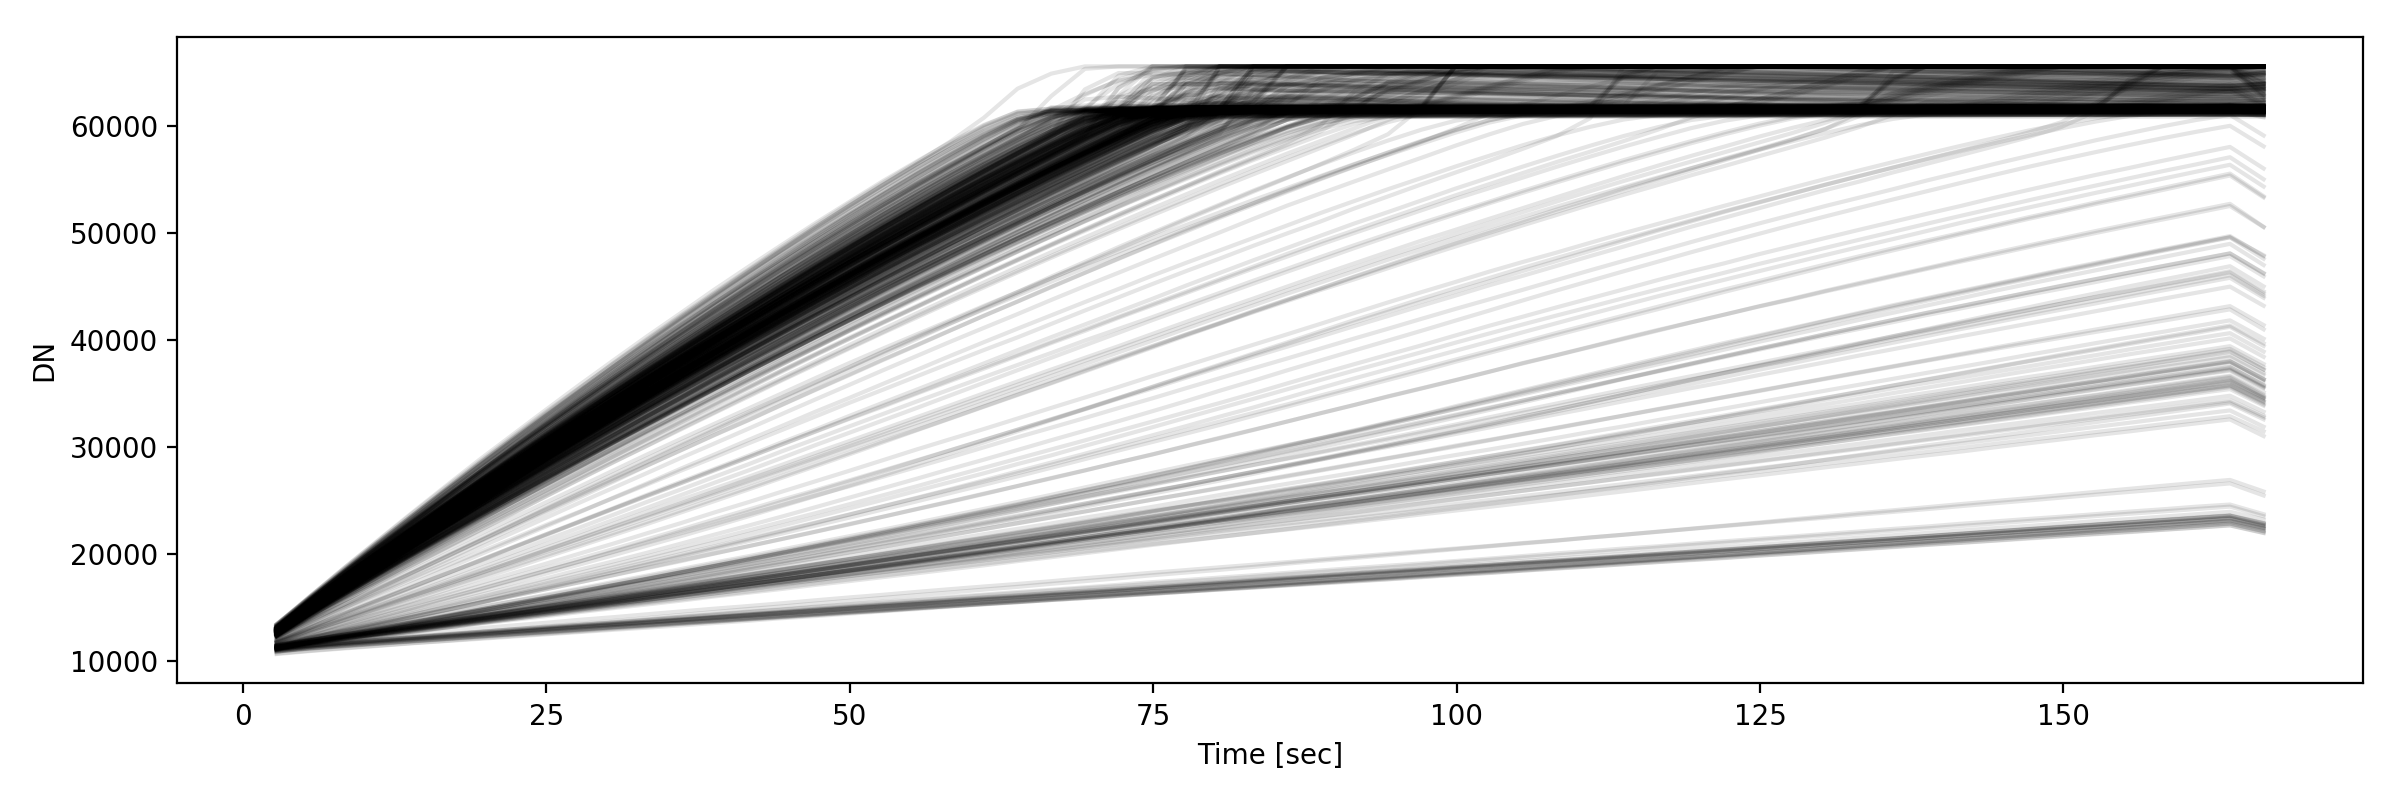

In [6]:
plt.close('all')
plt.figure(figsize=(12,4))
for ypos,xpos in itertools.product([10],range(10,512)):
    time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
    if analyze_ramp != 1:
        time = time-time[0]+frame_delta_time
    tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
    time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
    time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
    plt.plot(time,tramp,'k',alpha=0.1)
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.tight_layout()

### Remarks:
An MRS image covers a wide dynamic range of absolute DN values, we can use these to determine if there is a relation between the Y-intercept (DN at time 0) and the slope value (DN/sec).

## Derive Y-intercept values and slope values for all pixels in the specified spectral band

In [ ]:
# initialize placeholders
bias_map,linear_term_map = [np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64) for i in range(2)]

for ypos,xpos in itertools.product(range(1024),range(6,512)):
    if (xpos==511) & (ypos%100 == 0):
        print 'Row {}'.format(ypos)
    try:
        time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
        if analyze_ramp != 1:
            time = time-time[0]+frame_delta_time
        tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

        # derive non-linearity correction
        intime = time3
        inramp = tramp3

        num_samples = inramp.size
        assert (num_samples > order + 3), 'Not enough samples for pixel (X,Y) = ({},{}) to derive a non-linearity correction'.format(xpos,ypos)

        bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, order)

        # insert results in placeholder array
        bias_map[ypos,xpos],linear_term_map[ypos,xpos] = bias,linear_term
    except:
        pass

In [ ]:
plt.close('all')
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].imshow(bias_map,vmin=9000,vmax=12000)
axs[0].set_title('Bias')
axs[1].imshow(linear_term_map,vmin=linear_term_map[np.nonzero(linear_term_map)].min(),vmax=linear_term_map[np.nonzero(linear_term_map)].max())
axs[1].set_title('Linear term')
plt.tight_layout()

# Quadratic term shows imprint of fringes; this is most likely due to the DN dependence of the non-linearity. 
# On a fringe peak the DN are higher thus the non-linearity is more severe and the ramp is more bent (and vice-versa for a fringe peak trough).

<IPython.core.display.Javascript object>


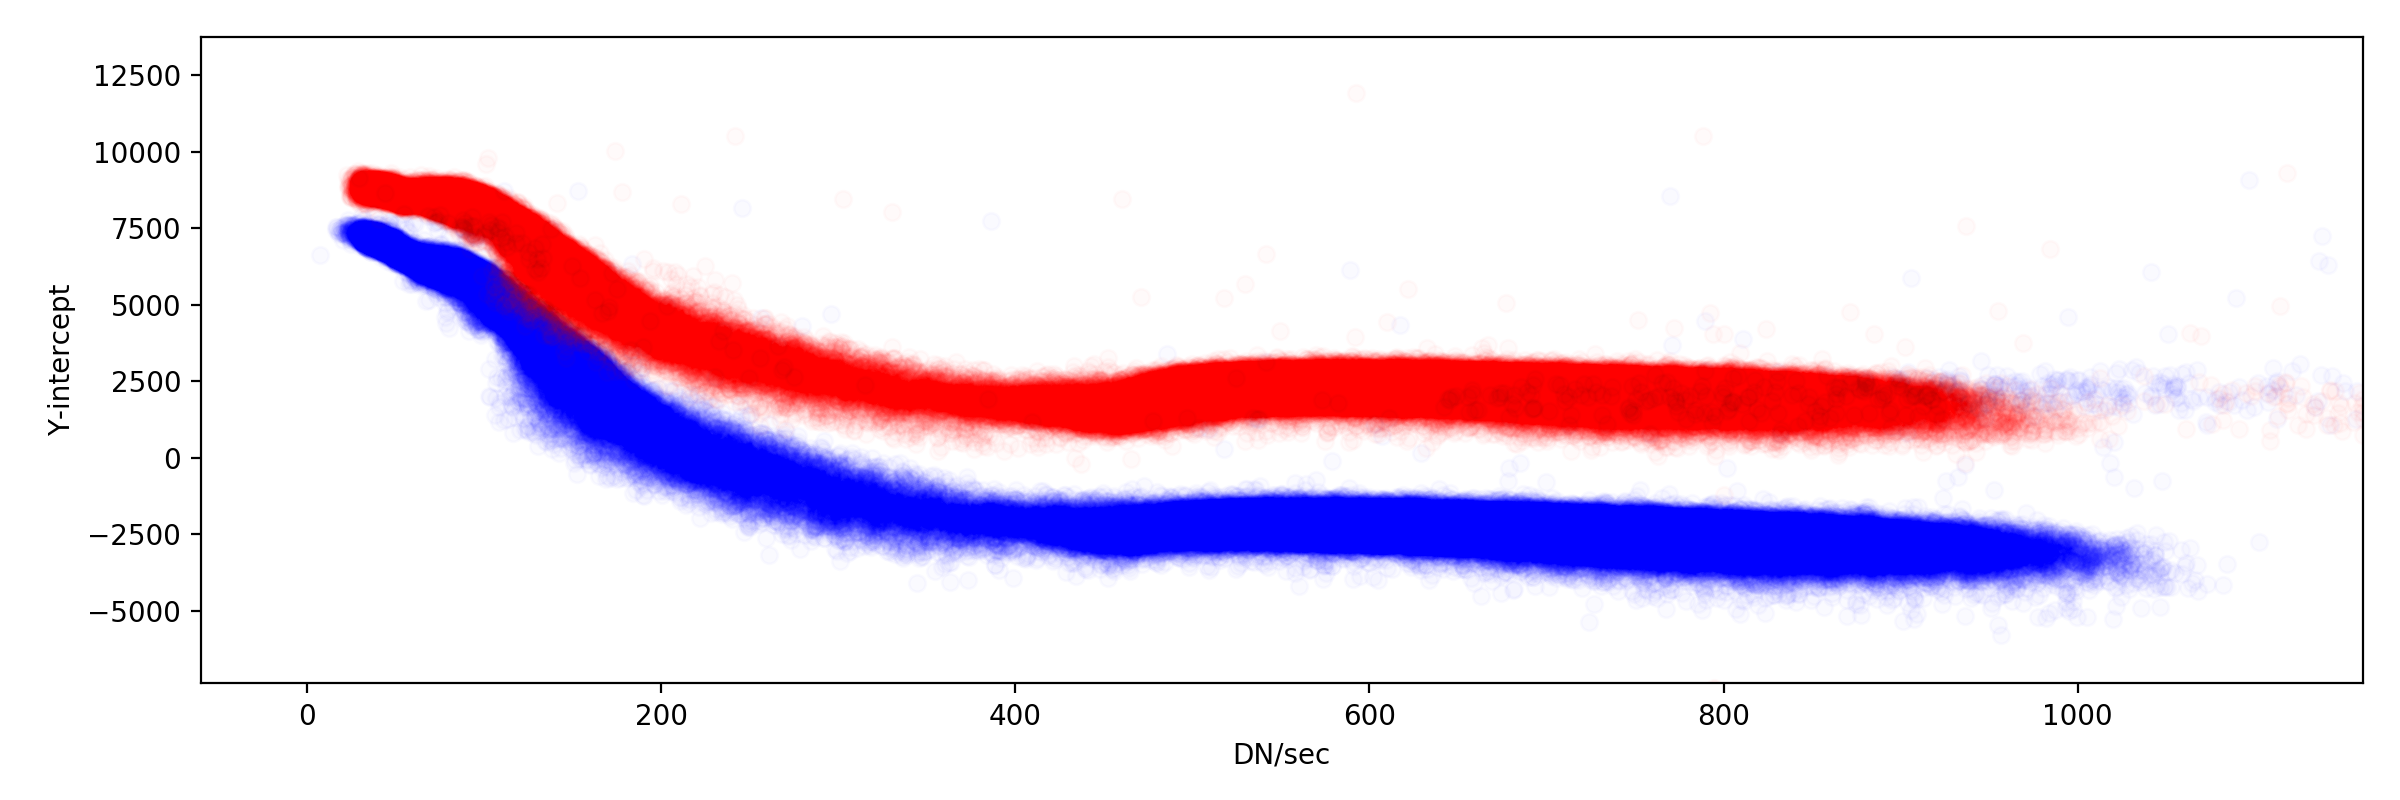

In [34]:
plt.close('all')
plt.figure(figsize=(12,4))
plt.plot(linear_term_map[1::2,:][np.nonzero(linear_term_map[1::2,:])].flatten(),bias_map[1::2,:][np.nonzero(bias_map[1::2,:])].flatten(),'bo',alpha=0.02)
plt.plot(linear_term_map[::2,:][np.nonzero(linear_term_map[::2,:])].flatten(),bias_map[::2,:][np.nonzero(bias_map[::2,:])].flatten(),'ro',alpha=0.02)
# plt.xlim(0,1000)
# plt.ylim(8000,13000)
plt.xlabel('DN/sec')
plt.ylabel('Y-intercept')
plt.tight_layout()

In [11]:
bias_map_dic,linear_term_map_dic = {},{}
bias_map_dic[band],linear_term_map_dic[band] = bias_map,linear_term_map

### Remarks:
* Integration ramp 1 shows a Y-intercept that is not correlated to the slope (the relation is horizontal). This cannot be used in any way. That said the relation is consistent for different MRS bands.
* Integration ramp 2 shows that there is correlation (i.e. the result is different than for integration ramp 1), but the scatter is still very large.
* A distinction between odd and even rows is clearly visible for most bands. Interestingly enough, band 1B, 2B, and 3C do not show a distinction between odd and even, however the slopes also seems to be much lower (there seems to be something off in those exposures).

# Multi-band analysis

In [15]:
# bias_map_dic,linear_term_map_dic = {},{}

for band in ['1C']:
    print 'Band {}'.format(band)
#     # CV3 MIRM33541
#     if band in ['1A','2A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits'
#     elif band in ['1B','2B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_495_SE_2016-01-19T10h33m18.fits'
#     elif band in ['1C','2C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_495_SE_2016-01-19T11h07m48.fits'
#     elif band in ['3A','4A']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_494_SE_2016-01-19T09h59m18.fits'
#     elif band in ['3B','4B']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-B-B-8MA-6019101921_1_494_SE_2016-01-19T10h33m19.fits'
#     elif band in ['3C','4C']:
#         filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-C-C-8MA-6019105515_1_494_SE_2016-01-19T11h07m48.fits'
    # CV3 MIRM108 (ramps purposed for non-linearity correction)
    if band in ['1A','2A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits'
    elif band in ['1B','2B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_494_SE_2016-01-21T20h36m13.fits'
    elif band in ['1C','2C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_495_SE_2016-01-21T21h49m12.fits'
    elif band in ['3A','4A']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-MEDIUM-6021204423_1_494_SE_2016-01-21T21h49m12.fits'
    elif band in ['3B','4B']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_495_SE_2016-01-21T22h32m32.fits'
    elif band in ['3C','4C']:
        filename = '/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-LONG-6021214250_1_494_SE_2016-01-21T22h32m32.fits'
    image_hdu = fits.open(filename)
    image_data = fits.getdata(filename)[:,:1024,:].astype('float')

    #
    image_shape = image_data.shape
    nints       = image_hdu[0].header['NINT']
    ngroups     = image_hdu[0].header['NGROUP']
    nframes     = image_shape[0]
    frame_delta_time = image_hdu[0].header['TFRAME']

    # initialize placeholders
    bias_map,linear_term_map = [np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64) for i in range(2)]
    
    if band[0] in ['1','4']:
        range_x = range(6,512)
    elif band[0] in ['2','3']:
        range_x = range(512,1026)
        
    for ypos,xpos in itertools.product(range(1024),range_x):
        if (xpos==511) & (ypos%100 == 0):
            print 'Row {}'.format(ypos)
        try:
            time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

            # derive non-linearity correction
            intime = time3
            inramp = tramp3

            num_samples = inramp.size
            assert num_samples > order + 3, 'Not enough samples to derive a non-linearity correction'

            bias,linear_term,quad_term,cubic_term = np.polynomial.polynomial.polyfit(intime, inramp, order)

            # insert results in placeholder array
            bias_map[ypos,xpos],linear_term_map[ypos,xpos] = bias,linear_term
        except:
            pass

    bias_map_dic[band] = bias_map
    linear_term_map_dic[band] = linear_term_map

Band 1C
Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


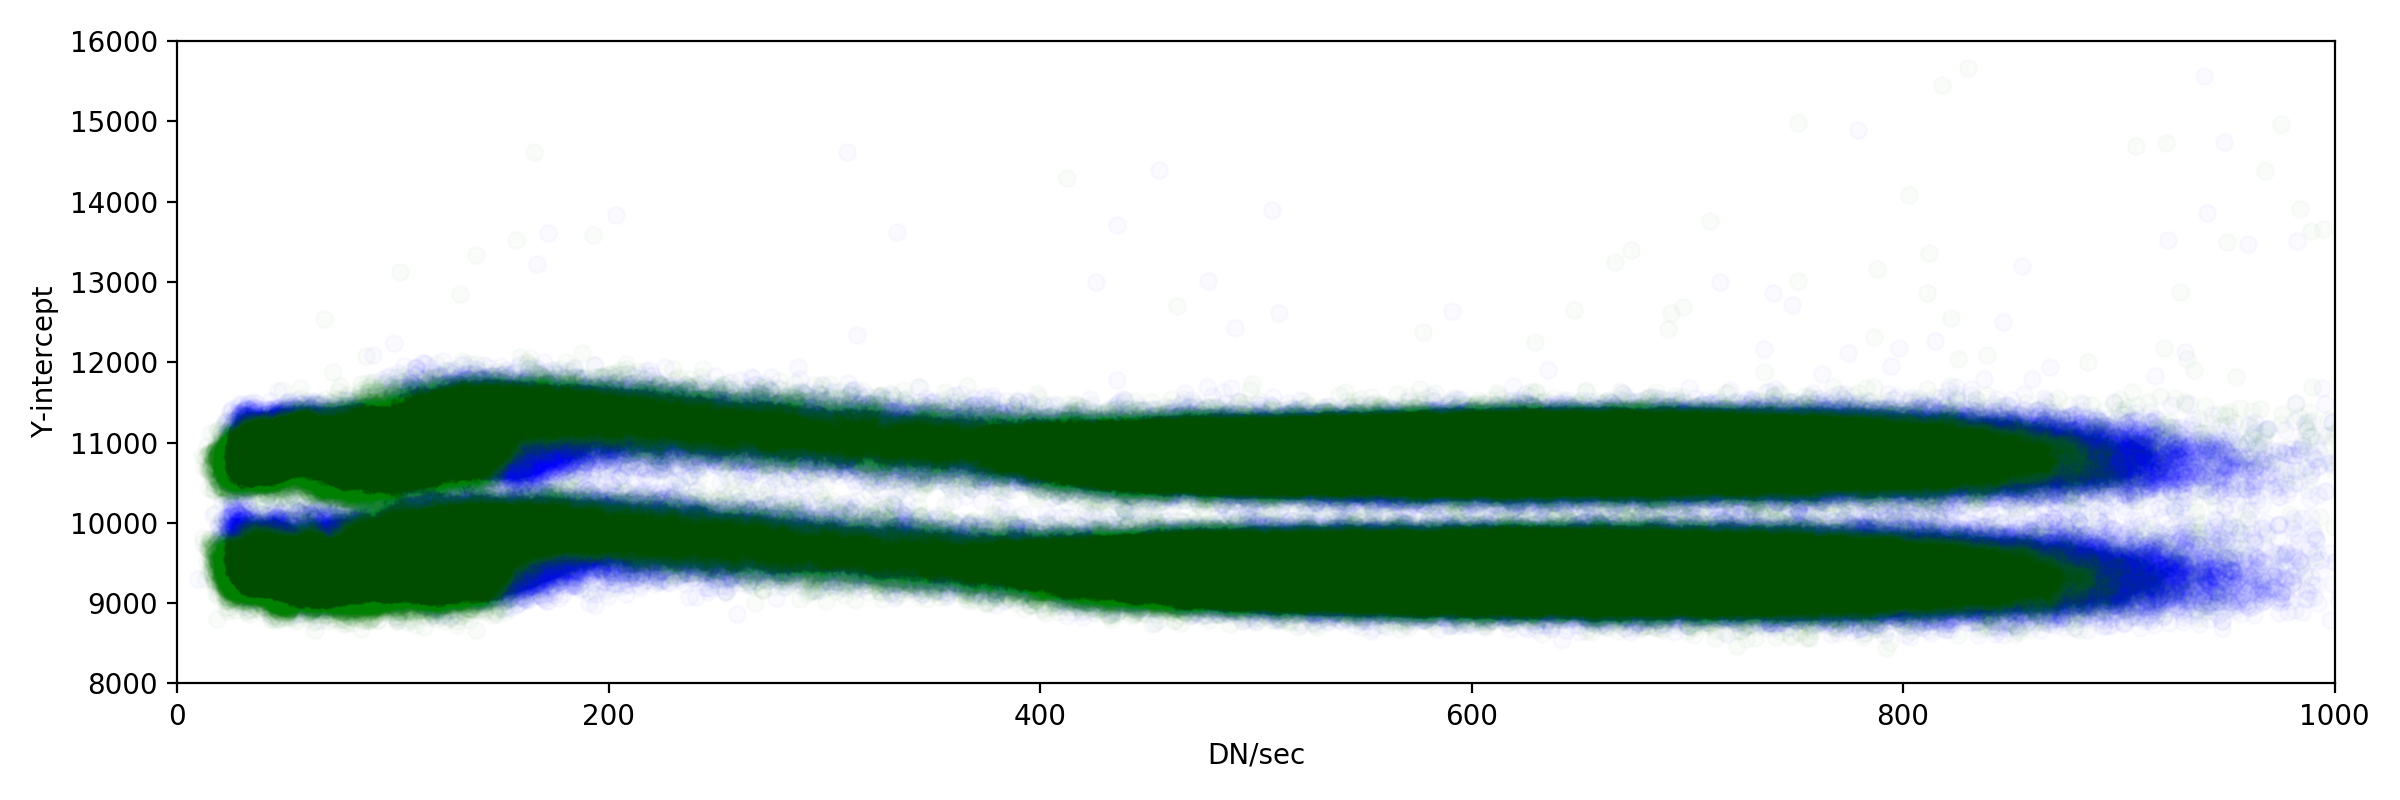

In [16]:
plt.close('all')
plt.figure(figsize=(12,4))
colors = {'1A':'b','1B':'orange','1C':'g','2A':'r','2B':'cyan','2C':'gray'}
for band in ['1A','1C']:
    plt.scatter(linear_term_map_dic[band][np.nonzero(linear_term_map_dic[band])].flatten(),bias_map_dic[band][np.nonzero(bias_map_dic[band])].flatten(),c=colors[band],alpha=0.02)
plt.xlim(0,1000)
plt.ylim(8000,13000)
plt.xlabel('DN/sec')
plt.ylabel('Y-intercept')
plt.tight_layout()

<IPython.core.display.Javascript object>


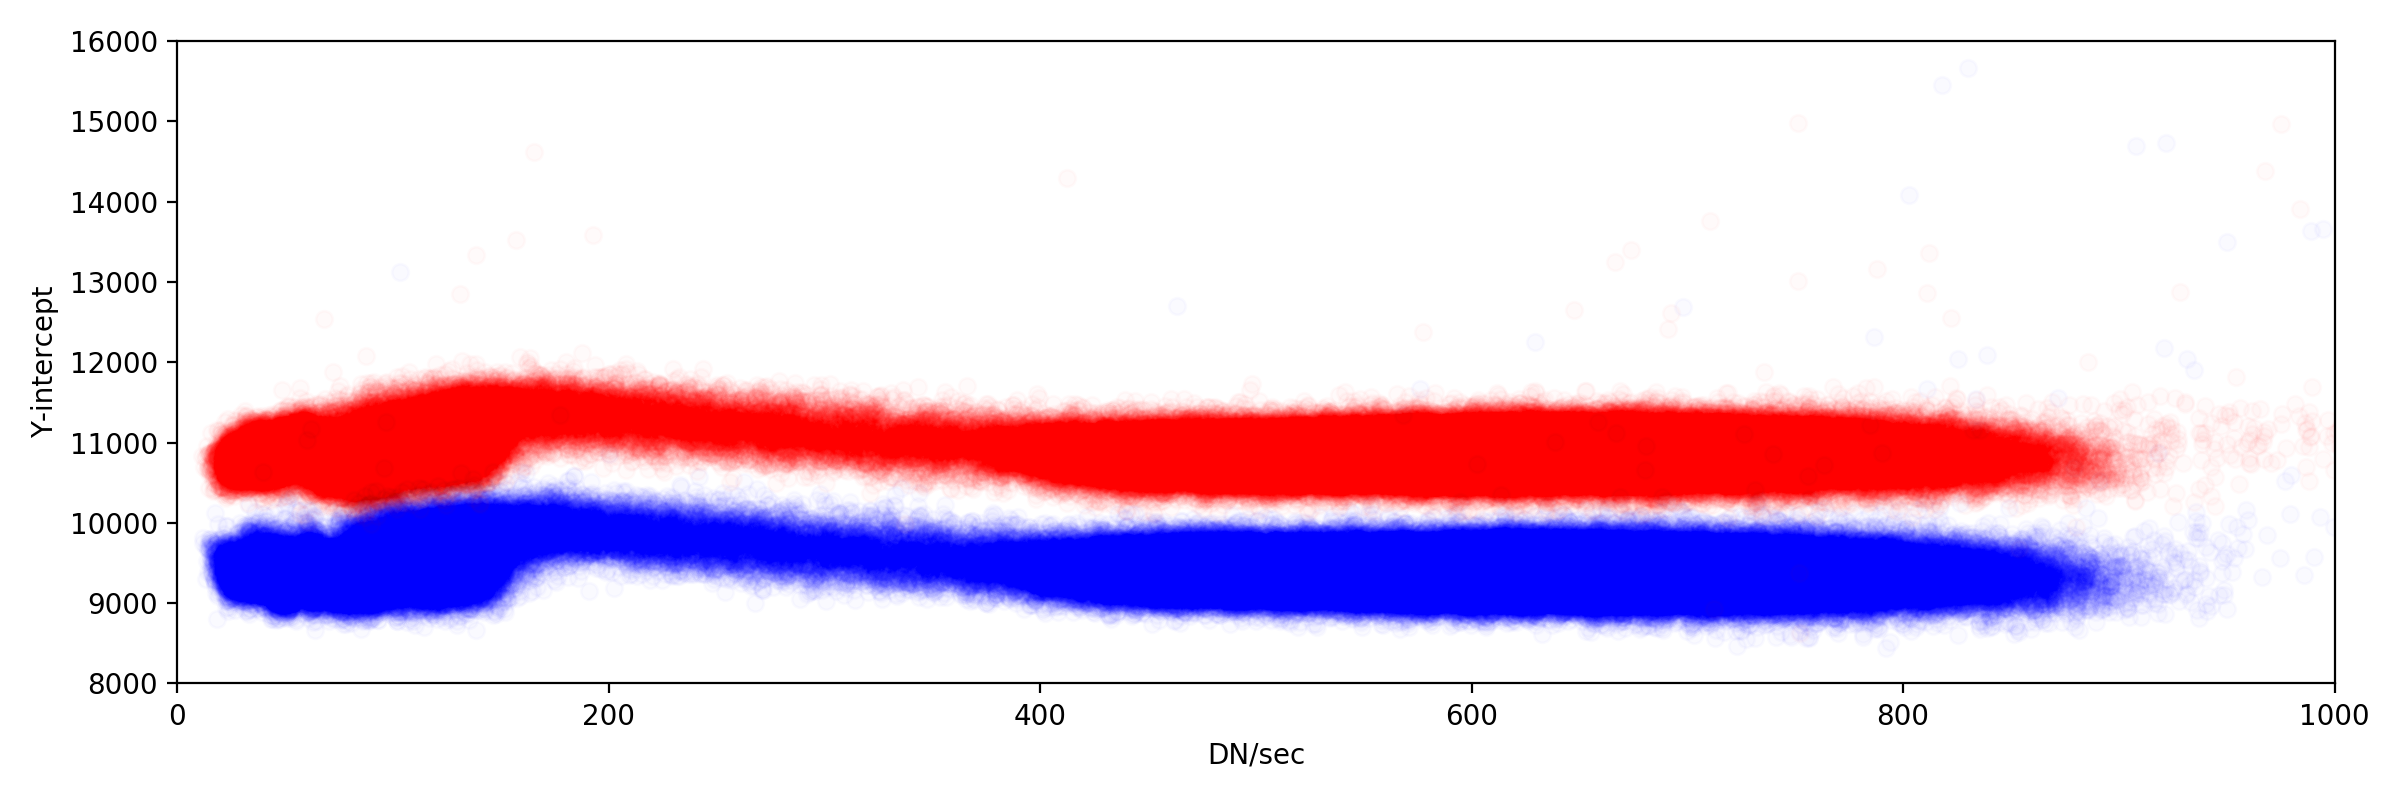

In [17]:
band = '1C'
plt.close('all')
plt.figure(figsize=(12,4))
plt.plot(linear_term_map_dic[band][1::2,:][np.nonzero(linear_term_map_dic[band][1::2,:])].flatten(),bias_map_dic[band][1::2,:][np.nonzero(bias_map_dic[band][1::2,:])].flatten(),'bo',alpha=0.02)
plt.plot(linear_term_map_dic[band][::2,:][np.nonzero(linear_term_map_dic[band][::2,:])].flatten(),bias_map_dic[band][::2,:][np.nonzero(bias_map_dic[band][::2,:])].flatten(),'ro',alpha=0.02)
plt.xlim(0,1000)
plt.ylim(8000,13000)
plt.xlabel('DN/sec')
plt.ylabel('Y-intercept')
plt.tight_layout()

In [18]:
funcs.save_obj(bias_map_dic,'CV3_MIRM108_IntegrationRamp{}_Yintercept'.format(analyze_ramp))
funcs.save_obj(linear_term_map_dic,'CV3_MIRM108_IntegrationRamp{}_Slope'.format(analyze_ramp))

In [19]:
CV3_MIRM108_IntegrationRamp1_Yintercept = funcs.load_obj('CV3_MIRM108_IntegrationRamp1_Yintercept')
CV3_MIRM108_IntegrationRamp1_Slope = funcs.load_obj('CV3_MIRM108_IntegrationRamp1_Slope')